In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Data Loader

In [2]:
# Install the ART library (Provides adversarial attacks)
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.5 MB/s eta 0:00:00


In [35]:
# Import libraries

# Libraries for data loading and processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#Libraries for convolutional CNN modeling
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten)
from keras.optimizers.legacy import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.applications import resnet50


#Libararies for adversarial attacks

# Installing ART Library
#!pip install adversarial-robustness-toolbox
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

# Time library
import datetime

# This line is important, without it the attacks in the ART toolbox won't work
# when using the Keras ART classifier
# And this line needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow
print("TensorFlow version:{}".format(tf.__version__))

TensorFlow version:2.15.0


In [4]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/GTSRB_dataset.zip

--2024-02-28 03:16:43--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/GTSRB_dataset.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123643346 (118M) [application/x-zip-compressed]
Saving to: ‘GTSRB_dataset.zip’

GTSRB_dataset.zip   100%[===================>] 117.92M  20.1MB/s    in 8.1s    

2024-02-28 03:16:52 (14.6 MB/s) - ‘GTSRB_dataset.zip’ saved [123643346/123643346]



In [5]:
# Uncompress the dataset
!unzip -uq 'GTSRB_dataset.zip' -d 'sample_data/'

In [6]:
# Path to the directory containing the dataset
DATA_DIR = 'sample_data/GTSRB_dataset/'

In [7]:
# Function for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.
        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.
        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = (x/255).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x/255).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(DATA_DIR + 'train.p', ['features', 'labels'])
        x_val, y_val = load_pickled_data(DATA_DIR + 'valid.p', ['features', 'labels'])
        x_test, y_test = load_pickled_data(DATA_DIR + 'test.p', ['features', 'labels'])
    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [8]:
# Load the images and labels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB()

In [9]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

Images train shape: (34799, 32, 32, 3) - Labels train shape: (34799,)
Images validation shape: (4410, 32, 32, 3) - Labels validation shape: (4410,)
Images test shape: (12630, 32, 32, 3) - Labels test shape: (12630,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.3242268
Data type float32


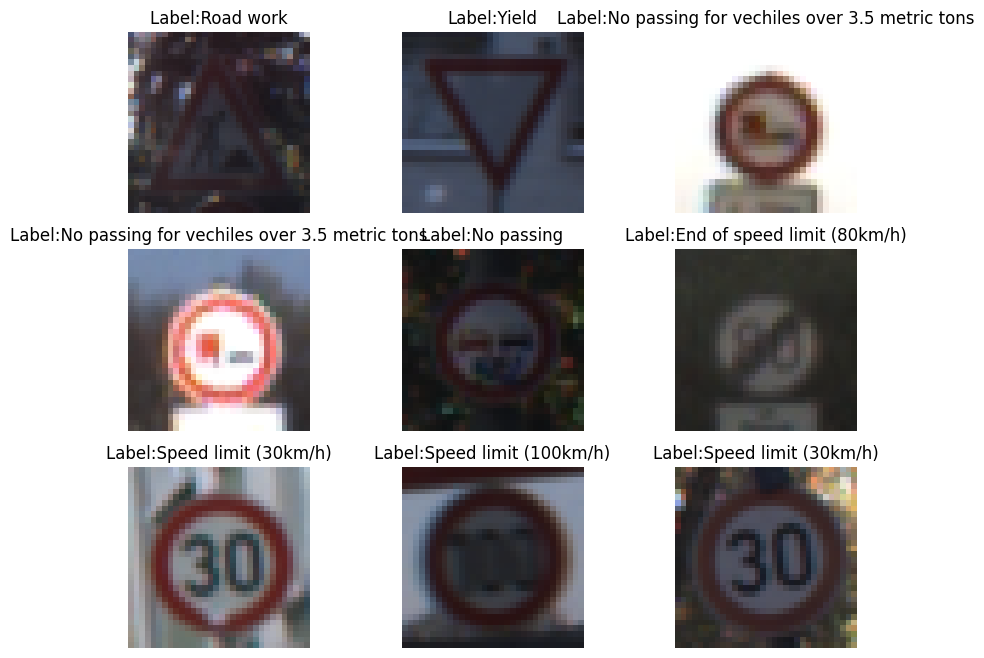

In [11]:
# Read the sign names
label_names = pd.read_csv('sample_data/GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(10, 8))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(label_names[labels_train[i[0]]]))
    plt.axis('off')

### Task 1: Train a convolutional NN for classification of the traffic signs in the dataset.

In [12]:
# define the parameters needed
IMG_HEIGHT = 32
IMG_WIDTH = 32
OUT_DIM = 43
BATCH_SIZE = 128

In [13]:
# follow the logic in the above cell, I change resnet as the following

class CNN_GTSRB(Model):

    def __init__(self, n_units):
        super().__init__()

        # here I add a function resnet50.ResNet50(), it will be the first layer in call() function
        self.resnet50 = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        # global average pooling
        self.globalaveragepooling2d = GlobalAveragePooling2D()

        # fully connect network
        self.dense1 = Dense(n_units, activation='relu')
        self.dropout = Dropout(0.25)
        self.dense2 = Dense(256, activation='relu')
        self.dense3 = Dense(OUT_DIM, activation='softmax')

    def call(self,inputs):
        x = self.resnet50(inputs) # Here I put resnet as the first layer and linked it to inputs, which is the mode inputs
        x = self.globalaveragepooling2d(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        return x

In [ ]:
# Use grid search to find the best parameter for the input units and learning rate

n_units_range = [512, 1024, 2048]
lr_range = [1e-2, 1e-3, 1e-4, 1e-5]

for n in n_units_range:
    for lr in lr_range:
        cnn_GTSRB = CNN_GTSRB(n)

        cnn_GTSRB.compile(optimizer=Adam(learning_rate=lr),
                          loss=SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

        cnn_GTSRB.fit(imgs_train, labels_train, epochs=1, validation_data=(imgs_val, labels_val), batch_size=32)

        _,test_accuray = cnn_GTSRB.evaluate(imgs_test, labels_test)
        print(f'Units: {n}\tLearning rate: {lr}\tTest Accuracy{test_accuray:5.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Train on 34799 samples, validate on 4410 samples
34799/34799 [==============================] - ETA: 0s - loss: 3.6537 - accuracy: 0.0559

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



34799/34799 [==============================] - 145s 4ms/sample - loss: 3.6537 - accuracy: 0.0559 - val_loss: 3.5653 - val_accuracy: 0.0542
Units: 512	Learning rage: 0.01\Test Accuracy0.0588
Train on 34799 samples, validate on 4410 samples
34799/34799 [==============================] - 146s 4ms/sample - loss: 1.2800 - accuracy: 0.6396 - val_loss: 0.6366 - val_accuracy: 0.7925
Units: 512	Learning rage: 0.001\Test Accuracy0.7643
Train on 34799 samples, validate on 4410 samples
34799/34799 [==============================] - 147s 4ms/sample - loss: 1.5708 - accuracy: 0.5726 - val_loss: 0.9286 - val_accuracy: 0.7206
Units: 512	Learning rage: 0.0001\Test Accuracy0.7420
Train on 34799 samples, validate on 4410 samples
34799/34799 [==============================] - 150s 4ms/sample - loss: 3.6794 - accuracy: 0.1230 - val_loss: 3.3519 - val_accuracy: 0.2265
Units: 512	Learning rage: 1e-05\Test Accuracy0.2470


In [14]:
# train the model with the best hyper-parameters from grid search
# based on grid search across n_uits and learning rate.
# (u_units=1024, the best learning rate=0.001) and (u_units=2048, the best learning rate=0.0001) have similar test accuracy
# here use (u_units=2048, the best learning rate=0.0001)


cnn_GTSRB = CNN_GTSRB(n_units=2048)
callback = [EarlyStopping(monitor='val_loss', patience=10)]
cnn_GTSRB.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

t1 = datetime.datetime.now()
history1 = cnn_GTSRB.fit(imgs_train, labels_train,
                         epochs=100,
                         validation_data=(imgs_val, labels_val),
                         callbacks=callback,
                         batch_size=32)

# evaluate the model on test data
_,test_accuray = cnn_GTSRB.evaluate(imgs_test, labels_test)
t2 = datetime.datetime.now()
print(f'Test Accuracy: {test_accuray:5.4f}')
print('Training time: '.format(t2 - t2))

Instructions for updating:
Colocations handled automatically by placer.


94765736/94765736 [==============================] - 3s 0us/step
Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - ETA: 0s - loss: 1.2419 - accuracy: 0.6544

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


34799/34799 [==============================] - 105s 3ms/sample - loss: 1.2419 - accuracy: 0.6544 - val_loss: 0.8971 - val_accuracy: 0.7560
Epoch 2/100
34799/34799 [==============================] - 90s 3ms/sample - loss: 0.1819 - accuracy: 0.9475 - val_loss: 0.4948 - val_accuracy: 0.8746
Epoch 3/100
34799/34799 [==============================] - 89s 3ms/sample - loss: 0.0942 - accuracy: 0.9740 - val_loss: 0.4820 - val_accuracy: 0.8927
Epoch 4/100
34799/34799 [==============================] - 90s 3ms/sample - loss: 0.0734 - accuracy: 0.9804 - val_loss: 0.3458 - val_accuracy: 0.9170
Epoch 5/100
34799/34799 [==============================] - 89s 3ms/sample - loss: 0.0588 - accuracy: 0.9849 - val_loss: 0.4522 - val_accuracy: 0.9249
Epoch 6/100
34799/34799 [==============================] - 89s 3ms/sample - loss: 0.0518 - accuracy: 0.9875 - val_loss: 0.3299 - val_accuracy: 0.9347
Epoch 7/100
34799/34799 [==============================] - 89s 3ms/sample - loss: 0.0421 - accuracy: 0.9901 - v

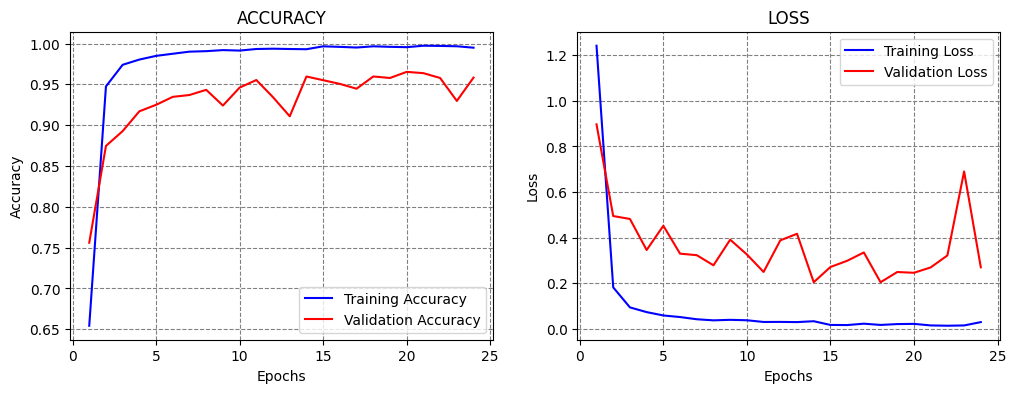

In [15]:
# plot the accuracy curve and loss curve

def plot_accuracy_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

plot_accuracy_loss(history1)

#### Task1 Report:

|    Training Accuracy   |   Validation Accuracy   |   Test Accuracy   |
|------------------------|-------------------------|-------------------|
|       0.9949           |         0.9583          |    0.9530         |



### Taks2: Implement an untargeted boundary attack against the trained model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


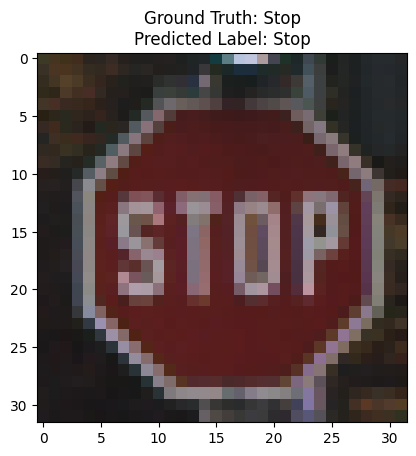

In [16]:
# choose index 111 from test dataset and print its ground turth and predicted lable
# select test image 111
img_111 = imgs_test[111]

#predict the label of test image 111
pre_probs = cnn_GTSRB.predict(img_111.reshape(1,32,32,3))
pre_label = np.argmax(pre_probs)

# plot the test image 111 with its ground truth label and predicted label
plt.imshow(img_111)
plt.title(f'Ground Truth: {label_names[labels_test[111]]}\nPredicted Label: {label_names[pre_label]}')
plt.show()

In [17]:
# define the classifier
classifier = KerasClassifier(clip_values=(0, 1), model=cnn_GTSRB)

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial at 0 step
l2_norm: 23.058717727661133 	label_index: 2 	label: Speed limit (50km/h)


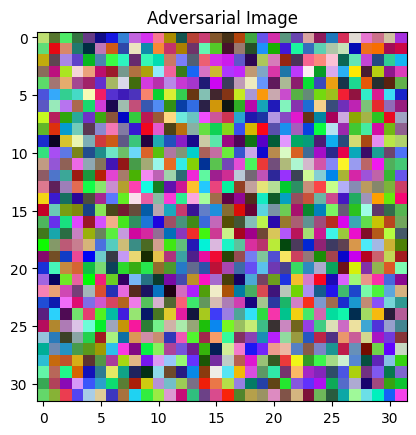

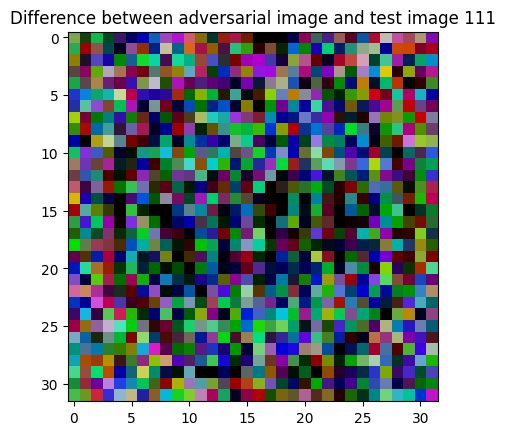

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 200 step
l2_norm: 1.8636456727981567 	label_index: 1 	label: Speed limit (30km/h)


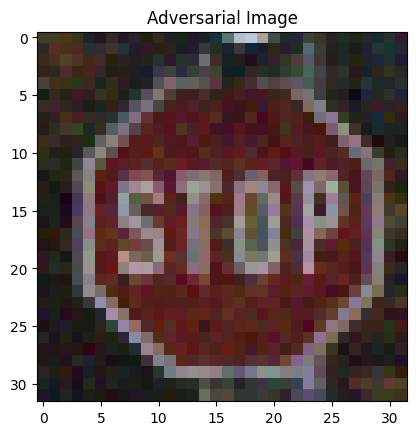

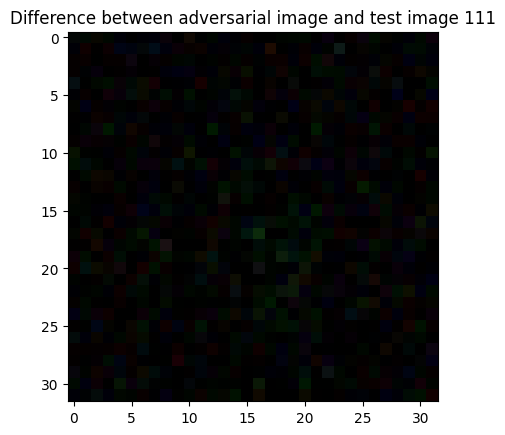

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 400 step
l2_norm: 1.825889229774475 	label_index: 2 	label: Speed limit (50km/h)


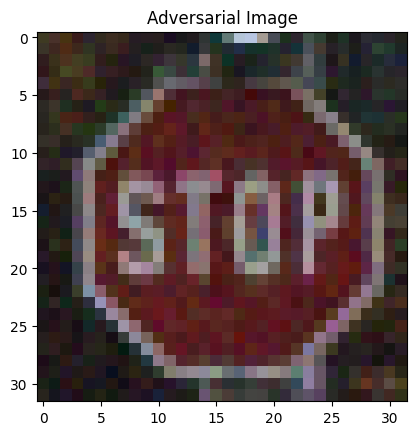

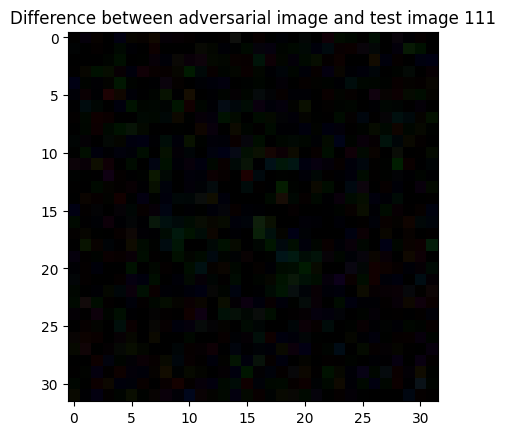

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 600 step
l2_norm: 1.9407362937927246 	label_index: 1 	label: Speed limit (30km/h)


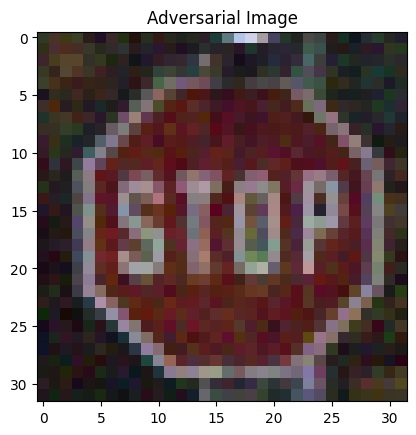

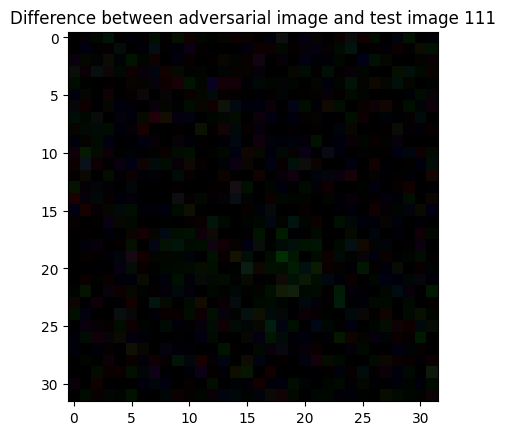

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 800 step
l2_norm: 1.8197834491729736 	label_index: 1 	label: Speed limit (30km/h)


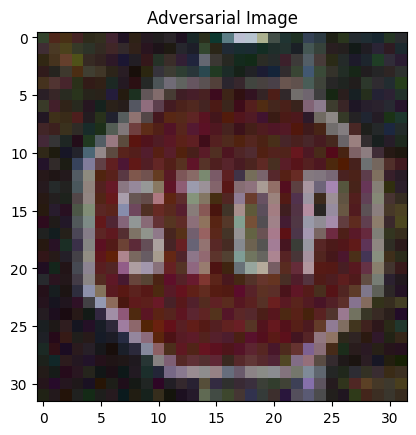

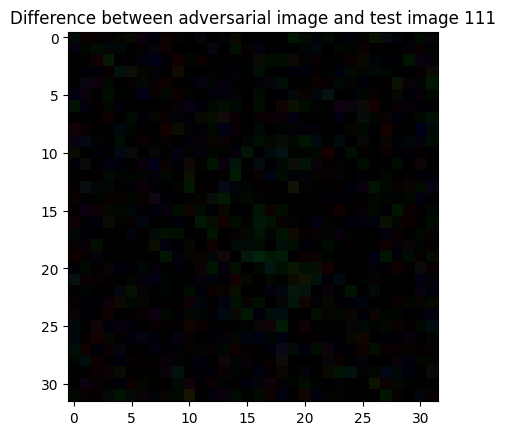

In [18]:
# define Boundary Attack
bound_atk = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200

# the initial adversarial image, it is random noise
img_adv_init = np.random.rand(1,32,32,3)

for i in range(5): # create 5 adversarial images for test image 111
    img_tobe_attacked = imgs_test[111].reshape(1,32,32,3) # the image to be attacked, i.e. test image 111
    img_adv = bound_atk.generate(x=img_tobe_attacked, x_adv_init=img_adv_init)

    #calculate the l2 norm between the img_tobe_attacked and the adversarial image
    l2_norm = np.linalg.norm(img_adv - img_tobe_attacked)

    # predicted label index of adversarial image
    label_index = np.argmax(classifier.predict(img_adv))

    # predicted lable name of adversarial image
    label = label_names[label_index]

    print(f'Adversarial at {i*iter_step} step\nl2_norm: {l2_norm} \tlabel_index: {label_index} \tlabel: {label}')

    # plot the adversarial image
    plt.imshow(img_adv.squeeze())
    plt.title('Adversarial Image')
    plt.show(block=False)

    # plot the difference between the adversarial image and the original image tobe attacke, i.e. test image 111
    plt.imshow((img_adv-img_tobe_attacked).squeeze())
    plt.title('Difference between adversarial image and test image 111')
    plt.show(block=True)

    if hasattr(bound_atk, 'curr_delta') and hasattr(bound_atk, 'curr_epsilon'):
        bound_atk.max_iter = iter_step
        bound_atk.delta = bound_atk.curr_delta
        bound_atk.epsilon = bound_atk.curr_epsilon
    else:
        break


**Task 2 Report:**

The overall observation is that I initialize an adversarial image to attack test image 111, the ground truth label of which is "stop". After 800 iteration, test image 111 was attacked as "Speed limit (30km/h)"

In the iteration process, I can see the initial adversarial images are much different from test image 111 and the l2 norm is also large. But after some iteration, the l2 norm decreased and the adversarial image become more and more similar to the test image 111. At the end of 800 iteration, I even can't see any difference between adversarail image and test image 111. But the model predicted another label other than "stop"

In the process, I am curious about what happens in function generate(), I want to know how it actually generates an adversarial image.
    

### Task 3: Implement a targeted boundary attack against the trained model

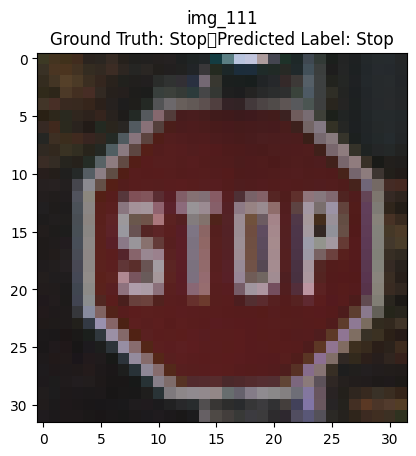

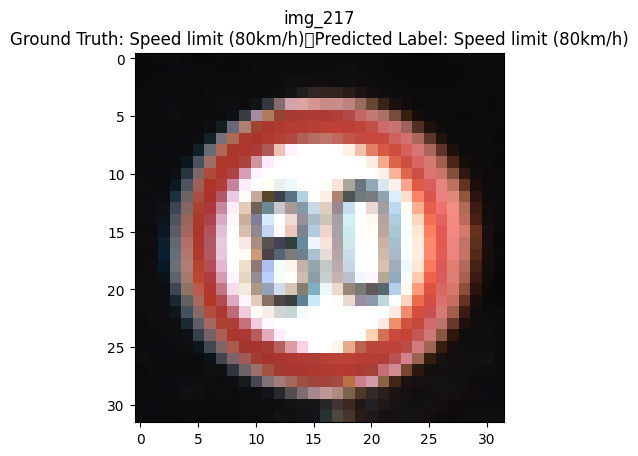

In [26]:
# select test image 111
img_111 = imgs_test[111]

# select test image 217
img_217 = imgs_test[217]

# predict the label of img_111 and img_217 with trained model cnn_GTSRB
pre_probs_111 = cnn_GTSRB.predict(img_111.reshape(1,32,32,3))
pre_label_111 = np.argmax(pre_probs_111)

pre_probs_217 = cnn_GTSRB.predict(img_217.reshape(1,32,32,3))
pre_label_217 = np.argmax(pre_probs_217)

# plot the img_111 and img_217 with their ground truth and prediected label
plt.imshow(img_111)
plt.title(f'img_111\nGround Truth: {label_names[labels_test[111]]}\tPredicted Label: {label_names[pre_label_111]}')
plt.show()

plt.imshow(img_217)
plt.title(f'img_217\nGround Truth: {label_names[labels_test[217]]}\tPredicted Label: {label_names[pre_label_217]}')
plt.show()

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial at 0 step
l2_norm: 19.395092010498047 	label_index: 5 	label: Speed limit (80km/h)


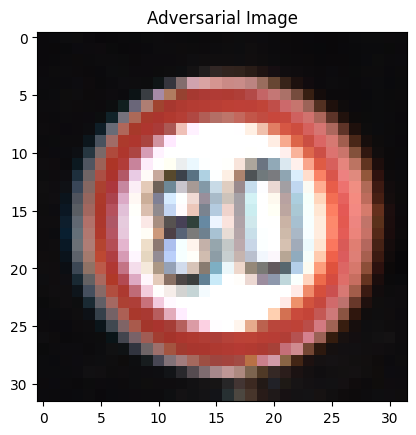

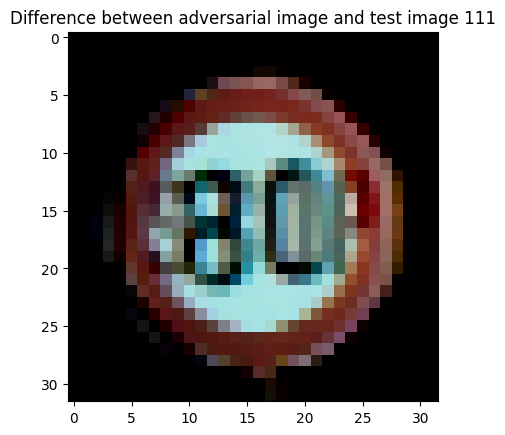

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 200 step
l2_norm: 1.9531311988830566 	label_index: 5 	label: Speed limit (80km/h)


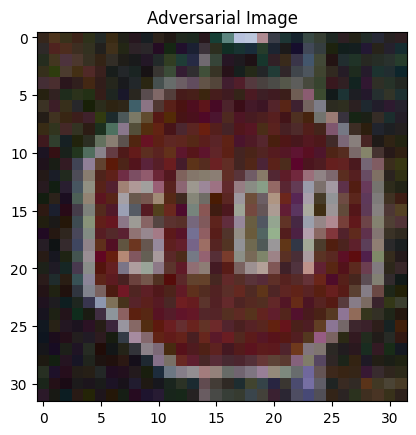

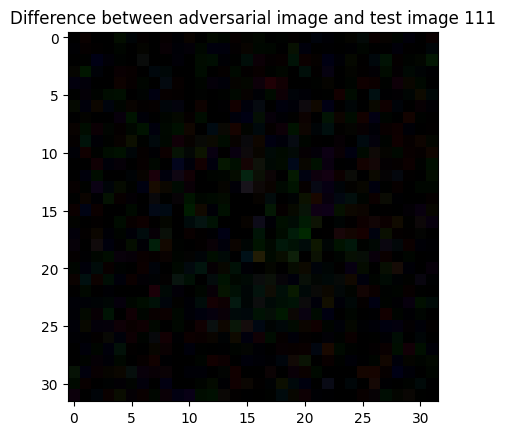

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 400 step
l2_norm: 1.738825798034668 	label_index: 5 	label: Speed limit (80km/h)


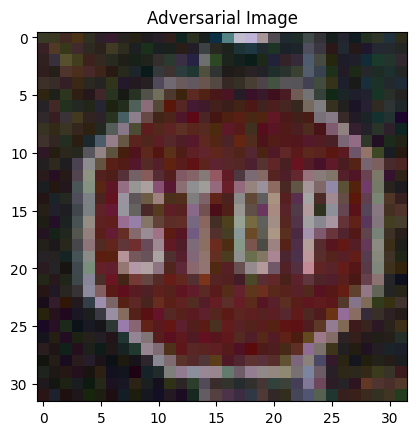

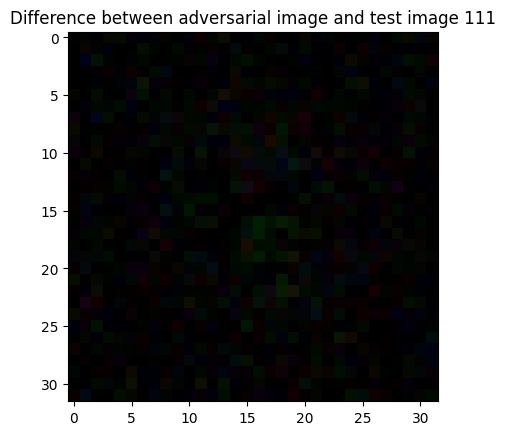

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 600 step
l2_norm: 1.7702056169509888 	label_index: 5 	label: Speed limit (80km/h)


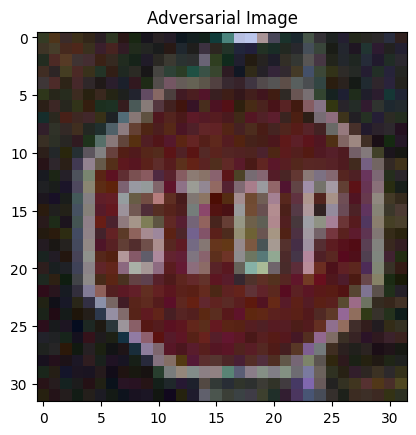

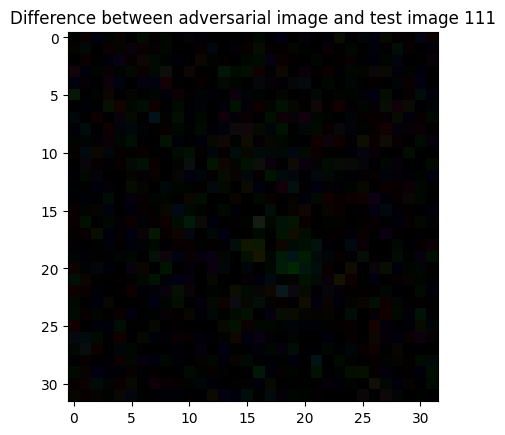

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial at 800 step
l2_norm: 1.7567331790924072 	label_index: 5 	label: Speed limit (80km/h)


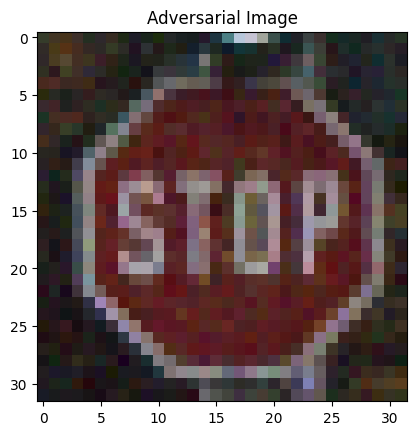

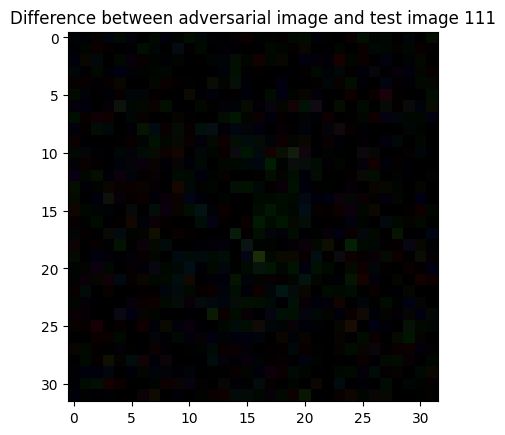

In [68]:
# Define the targeted boundary attack
boundary_atk_tgt = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200

# the initial adversarial image starting from img_111
init_adv_img217 = img_217.reshape(1,32,32,3)
# targeted image img_217
tgt_img111 = img_111.reshape(1,32,32,3)

for i in range(5): # create 5 adversarial images
     # the targeted image
    img_adv = boundary_atk_tgt.generate(x=tgt_img111, y=to_categorical([5], 43), x_adv_init=init_adv_img217)
    # calculate the l2 norm distance between target image and adversarial image
    l2_norm = np.linalg.norm(img_adv - tgt_img111)

    # predict the label index of the adversarial image
    label_index = np.argmax(classifier.predict(img_adv))

    # predict the label name of the adversarial image
    label = label_names[label_index]

    print(f'Adversarial at {i*iter_step} step\nl2_norm: {l2_norm} \tlabel_index: {label_index} \tlabel: {label}')

    # plot the adversarial image
    plt.imshow(img_adv.squeeze())
    plt.title('Adversarial Image')
    plt.show(block=False)

    # plot the difference between the adversarial image and the target image, i.e. test image 217
    plt.imshow((img_adv-tgt_img111).squeeze())
    plt.title('Difference between adversarial image and test image 111')
    plt.show(block=True)

    if hasattr(boundary_atk_tgt, 'curr_delta') and hasattr(boundary_atk_tgt, 'curr_epsilon'):
        boundary_atk_tgt.max_iter = iter_step
        boundary_atk_tgt.delta = boundary_atk_tgt.curr_delta
        boundary_atk_tgt.epsilon = boundary_atk_tgt.curr_epsilon
    else:
        break

**Task 3 Report:**

The overall observation is we attack test image 111 with "stop" label to be "Speed limit (80km/h)" label. At the beginning iteration, the adversarial image is very similar to "Speed limit (80km/h)" image and model predicted it as "Speed limit (80km/h)" label. The l2 norm between the adversarial image and test image 111 is also large at the begining iteration;

After several iteration, the adversarial image becomes more and more like test iamge 111 and the l2 norm between them went smaller and smaller. At the end of the iteration, the adversarial image is very similar to test image 111, I even can't find difference between the two image. I think the label of the adversarial image should be "stop". But the model keeps missclassified the adversarial image as "Speed limit (80km/h)". 

In the process, I am still curious about what happens in function generate(), I want to know how it actually generates an adversarial image.
    